In [3]:
!pip install contextily #not sure what this is for 
import contextily as cx

  Obtaining dependency information for contextily from https://files.pythonhosted.org/packages/d2/84/dbcd682289fe8fa3f7c16318e06a7626608f767a9a163954df58f245adef/contextily-1.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e5/15/cf2a69ade4b194aa524ac75112d5caac37414b20a3a03e6865dfe0bd1539/geopy-2.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for mercantile from https://files.pythonhosted.org/packages/b2/d6/de0cc74f8d36976aeca0dd2e9cbf711882ff8e177495115fd82459afdc4d/mercantile-1.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for geographiclib<3,>=1.52 from https://files.pythonhosted.org/packages/9f/5a/a26132406f1f40cf51ea349a5f11b0a46cec02a2031ff82e391c2537247a/geographiclib-2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ----------------------------- ---------- 92.2/125.4 kB 2.6 MB/s eta 0:00:01
   ------------------------

In [2]:
# Import required packages
import matplotlib as mpl
from matplotlib import colors

%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) #this increases the inline figure size to 15 tall x 10 wide

import seaborn
import pandas as pd
import geopandas as gpd
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # Change settings so that warnings are not displayed


from shapely.geometry import Polygon
import plotly.express as px
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.moran import Moran_Local

# Loading a few new packages
from scipy import stats
from pysal.model import spreg
import statsmodels.formula.api as sm

In [3]:
#Import datasets 
hp = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/houses_lr(1).geojson')
oa = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/OutputAreas.geojson')
lb = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/london_boroughs.geojson')
schools = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/all_schools_xy_2016(1).csv')

In [4]:
from pyproj import CRS, Transformer

In [6]:
#Converting coordinates in school dataset to a point geom in the same CRS as house price data and then calculating distance
from shapely.geometry import Point

hp17 = hp[(hp["year"]==2017)] #going for 2017 since our schools dataset is from 2016

crs_27700 = CRS("EPSG:27700")
crs_4326 = CRS("EPSG:4326")

transformer = Transformer.from_crs(crs_4326, crs_27700, always_xy=True)
schools['geometry'] = [Point(transformer.transform(lon, lat)) for lon, lat in zip(schools['x'], schools['y'])]

#now calculate distance
hp_school_dist = hp17.geometry.apply(lambda x: schools.distance(x).min())

#Merge distances back into hp dataset
hp_with_school_dist = pd.concat([hp17, hp_school_dist.rename("Dist_School")], axis=1)

hp_with_school_dist = gpd.GeoDataFrame(hp_with_school_dist, geometry='geometry', crs=hp17.crs)

#Export new dataset#
# Export the final dataset with calculated distance variables to a new GeoJSON file
hp_with_school_dist.to_file("houses_with_school_distance.geojson", driver='GeoJSON', schema={"geometry": "Point", "properties": {"postcode": "str", "price": "float", "dateoftransfer": "str", "propertytype": "str", "oldnew": "str", "duration": "str", "categorytype": "str", "recordstatus": "str", "year": "float", "tfarea": "float", "numberrooms": "float", "priceper": "float", "pcd": "str", "pcd2": "str", "dointr": "float", "doterm": "float", "Dist_School": "float"}})



In [7]:
hp_with_school_dist.tail(10)

postcode      price dateoftransfer propertytype oldnew duration  \
641116  SW1W9NX   960600.0     2017-09-29            T      N        F   
641135    W24AW  1700000.0     2017-03-07            T      N        F   
641147  SW118QQ   665000.0     2017-12-20            F      N        L   
641148  SW118NU  1400000.0     2017-10-30            F      N        L   
641149  SW118NR   975000.0     2017-11-10            F      N        L   
641153  SW118PP  1040000.0     2017-05-11            F      N        L   
641161   IG88BH   237500.0     2017-07-28            F      N        L   
641169  SW118NJ   230000.0     2017-11-08            F      N        L   
641178  SW118PG   790000.0     2017-07-27            F      N        L   
641179   KT64EP   250000.0     2017-01-31            F      N        L   

       categorytype recordstatus    year  tfarea  numberrooms      priceper  \
641116            A            A  2017.0   162.0          4.0   5929.629630   
641135            A            A  2017.0   112.0          5.0  15178.571429   
641147            A            A  2017.0    48.0          2.0  13854.166667   
641148            A            A  2017.0   111.0          3.0  12612.612613   
641149            A            A  2017.0    87.0          3.0  11206.896552   
641153            A            A  2017.0    79.0          3.0  13164.556962   
641161            A            A  2017.0    46.0          2.0   5163.043478   
641169            A            A  2017.0    49.0          2.0   4693.877551   
641178            A            A  2017.0    70.0          2.0  11285.714286   
641179            A            A  2017.0    67.0          3.0   3731.343284   

            pcd      pcd2    dointr  doterm                       geometry  \
641116  SW1W9NX  SW1W 9NX  198001.0     NaN  POINT (528535.000 178873.000)   
641135  W2  4AW  W2   4AW  198001.0     NaN  POINT (525773.000 180750.000)   
641147  SW118QQ  SW11 8QQ  201611.0     NaN  POINT (528644.000 177426.000)   
641148  SW118NU  SW11 8NU  201611.0     NaN  POINT (528621.000 177594.000)   
641149  SW118NR  SW11 8NR  201611.0     NaN  POINT (528686.000 177623.000)   
641153  SW118PP  SW11 8PP  201611.0     NaN  POINT (528632.000 177515.000)   
641161  IG8 8BH  IG8  8BH  198001.0     NaN  POINT (542758.000 191959.000)   
641169  SW118NJ  SW11 8NJ  201611.0     NaN  POINT (528688.000 177523.000)   
641178  SW118PG  SW11 8PG  201611.0     NaN  POINT (528621.000 177594.000)   
641179  KT6 4EP  KT6  4EP  200804.0     NaN  POINT (517818.000 167249.000)   

        Dist_School  
641116   295.216087  
641135    75.151144  
641147   508.071532  
641148   613.046459  
641149   546.617532  
641153   595.428649  
641161   496.380411  
641169   583.887279  
641178   613.046459  
641179   335.704111

In [8]:
#take the natural log of area and price as these are both right skewed
hp_with_school_dist['log_area'] = np.log(hp_with_school_dist['tfarea'])
hp_with_school_dist['log_price'] = np.log(hp_with_school_dist['price'])

In [11]:
#Need to create binary variables for property type and old/new
hp_with_school_dist['Detached'] = np.where(hp_with_school_dist['propertytype']=='D', 1, 0)
hp_with_school_dist['Flats'] = np.where(hp_with_school_dist['propertytype']=='F', 1, 0)
hp_with_school_dist['New'] = np.where(hp_with_school_dist['oldnew']=='Y', 1, 0)

#list of covariates
variable_names = ['log_area', 'numberrooms', 'Flats', 'Detached','New']

In [12]:
#first regression with only the covariates above 
model1 = spreg.OLS(hp_with_school_dist[['log_price']].values, hp_with_school_dist[variable_names].values,
                name_y='log_price', name_x=variable_names, robust='white')
print(model1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           6
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63495
R-squared           :      0.5336
Adjusted R-squared  :      0.5336
Sum squared residual:     9466.14                F-statistic           :  14529.6318
Sigma-square        :       0.149                Prob(F-statistic)     :           0
S.E. of regression  :       0.386                Log likelihood        :  -29672.198
Sigma-square ML     :       0.149                Akaike info criterion :   59356.395
S.E of regression ML:      0.3861                Schwarz criterion     :   59410.748

White Standard Errors
--------------------------------------

This is just a model with variables to do with housing characteristics before we look at relationship with schools as these are probably the biggest factors determining the price of a house. The R-squared here is 0.53 which is pretty good. Here I've skipped intrepreting the rest of this model as we know we want to add to it anyway. The next thing to look at is if the neighbourhood makes a difference to the house price - i.e. if adding a spatial component adds to our model. 



In [13]:
#Lets look at clustering in the model errors by neighbourhood. 

hp_with_school_dist2 = gpd.sjoin(hp_with_school_dist, oa)
pd.set_option('display.max_columns', None)
hp_with_school_dist2.head()

postcode      price dateoftransfer propertytype oldnew duration  \
6        CR30EA   252000.0     2017-10-26            T      N        F   
133190   CR30EA   315000.0     2017-04-06            T      N        F   
144109   CR30EA   315000.0     2017-07-24            T      N        F   
25      EC2Y8DD  1775000.0     2017-01-16            F      N        L   
676     EC2Y8NB  1950000.0     2017-10-06            F      N        L   

       categorytype recordstatus    year  tfarea  numberrooms      priceper  \
6                 A            A  2017.0   68.00          4.0   3705.882353   
133190            A            A  2017.0   77.00          4.0   4090.909091   
144109            A            A  2017.0   73.85          3.0   4265.402844   
25                A            A  2017.0  106.03          5.0  16740.545129   
676               A            A  2017.0  114.00          4.0  17105.263158   

            pcd      pcd2    dointr  doterm                       geometry  \
6       CR3 0EA  CR3  0EA  198001.0     NaN  POINT (533695.000 158978.000)   
133190  CR3 0EA  CR3  0EA  198001.0     NaN  POINT (533695.000 158978.000)   
144109  CR3 0EA  CR3  0EA  198001.0     NaN  POINT (533695.000 158978.000)   
25      EC2Y8DD  EC2Y 8DD  198001.0     NaN  POINT (532418.000 181908.000)   
676     EC2Y8NB  EC2Y 8NB  199208.0     NaN  POINT (532418.000 181908.000)   

        Dist_School  log_area  log_price  Detached  Flats  New  index_right  \
6        277.597109  4.219508  12.437184         0      0    0        18358   
133190   277.597109  4.343805  12.660328         0      0    0        18358   
144109   277.597109  4.302036  12.660328         0      0    0        18358   
25       131.350928  4.663722  14.389311         0      1    0        12125   
676      131.350928  4.736198  14.483340         0      1    0        12125   

         geo_code                        label          NAME_2    POP  \
6       E00005337  E92000001E09000008E00005337         Croydon  301.0   
133190  E00005337  E92000001E09000008E00005337         Croydon  301.0   
144109  E00005337  E92000001E09000008E00005337         Croydon  301.0   
25      E00000017  E92000001E41000324E00000017  City of London  290.0   
676     E00000017  E92000001E41000324E00000017  City of London  290.0   

          POPDENS     HH  HECTARES    DEPRHH EMPRES   STUDENT   PROFSCI  \
6        20.35159  119.0     14.79  0.478992    158  0.050926  0.097561   
133190   20.35159  119.0     14.79  0.478992    158  0.050926  0.097561   
144109   20.35159  119.0     14.79  0.478992    158  0.050926  0.097561   
25      171.59760  142.0      1.69  0.330986    158  0.071429  0.356250   
676     171.59760  142.0      1.69  0.330986    158  0.071429  0.356250   

        Trees  TreeDens  
6         0.0  0.000000  
133190    0.0  0.000000  
144109    0.0  0.000000  
25        8.0  4.733728  
676       8.0  4.733728

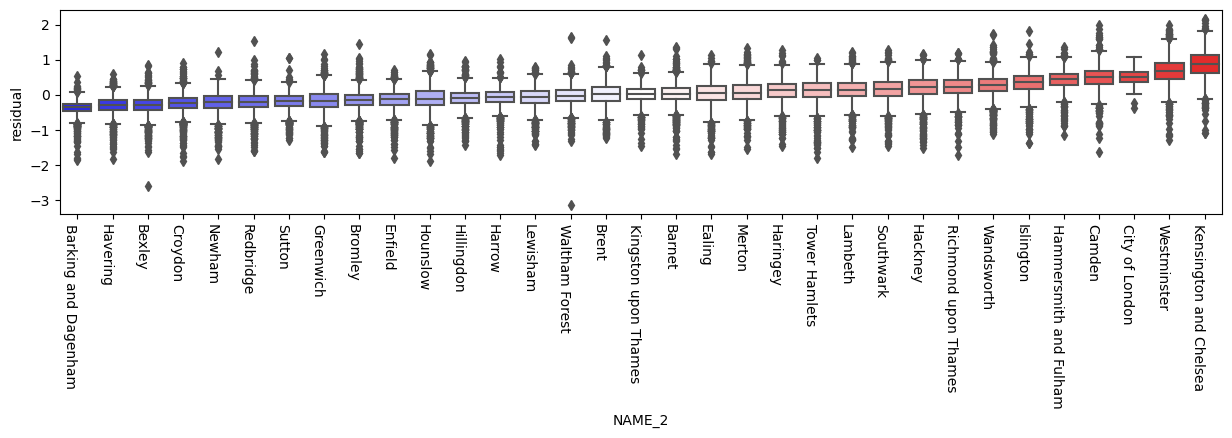

In [15]:
#Lets plot the distribution of model1's residuals by borough

hp_with_school_dist2['residual'] = model1.u
medians = hp_with_school_dist2.groupby("NAME_2").residual.median().to_frame('hood_residual')

f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot(
    x='NAME_2', 
    y='residual', 
    ax = ax,
    data=hp_with_school_dist2.merge(
        medians, how='left', left_on='NAME_2', right_index=True
    ).sort_values('hood_residual'), 
    palette='bwr',
)
# Rotate the X labels for legibility
f.autofmt_xdate(rotation=-90)
plt.show()

There is significant variation in how the model is working by neighbourhood. It appears that a lot of the boroughs on the high and low end of the residual spectrum are close to one-another in space. Lets test this by creating a distance-based spatial weights matrix and generating spatial lags of the residuals.

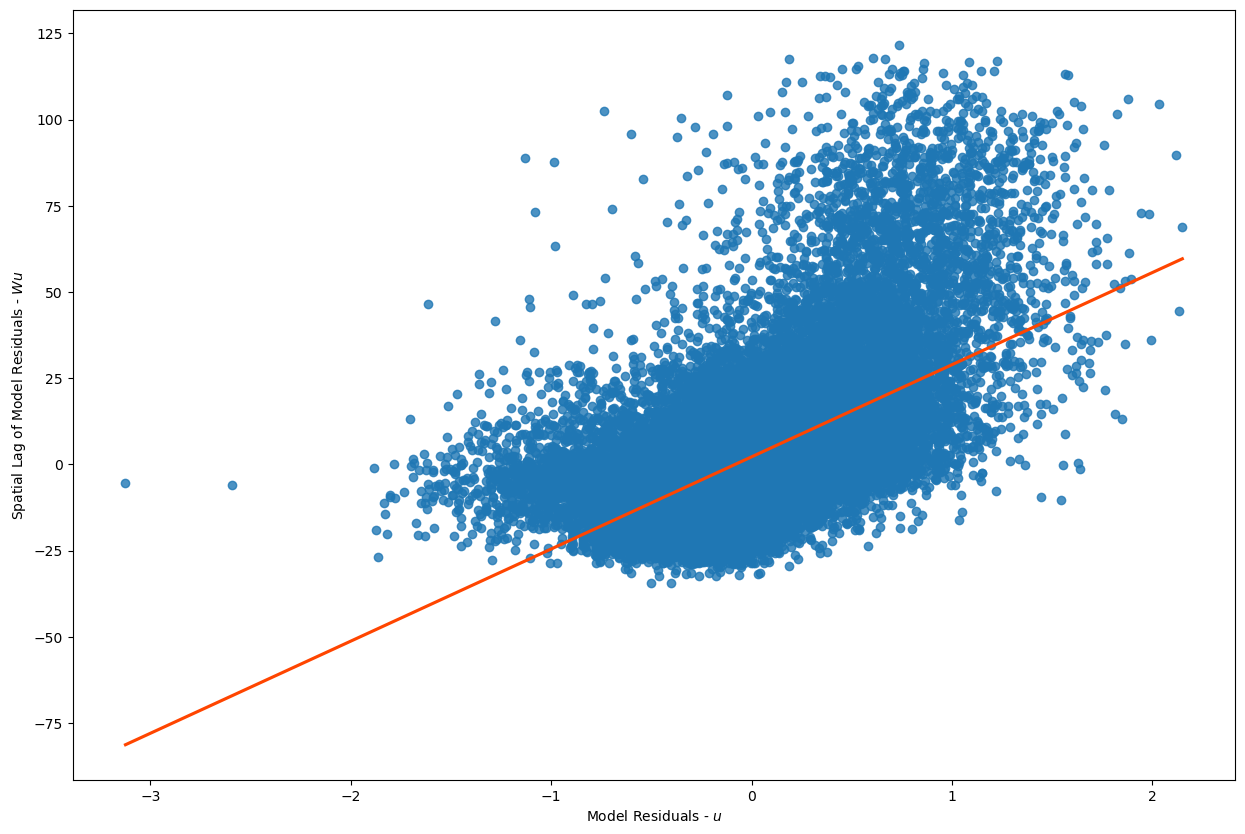

In [16]:
w = w = weights.DistanceBand.from_dataframe(hp_with_school_dist2, 500) # Weights based on features within 500 meters

#then correlate these spatially-lagged residuals with the residuals of the model in their origin locations:
lag_residual = weights.spatial_lag.lag_spatial(w, model1.u)
ax = seaborn.regplot(
    x=model1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None,
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

This shows that the prediction errors are clustering = violation of OLS assumption and shows that there are spatial processes structuring the relationship of the variables we've chosen to explain housing price. We can insert dummy variables for each borough directly to control for this (called a fixed effects model). 

In [19]:
fixedmodel = 'log_price ~ ' + ' + '.join(variable_names) + ' + NAME_2 - 1' # Remove intercept (-1) in this fixed effects model

model2 = sm.ols(fixedmodel, data=hp_with_school_dist2).fit()
print(model2.summary2())

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.774     
Dependent Variable:     log_price            AIC:                    13197.1187
Date:                   2024-03-29 15:27     BIC:                    13541.0556
No. Observations:       63005                Log-Likelihood:         -6560.6   
Df Model:               37                   F-statistic:            5827.     
Df Residuals:           62967                Prob (F-statistic):     0.00      
R-squared:              0.774                Scale:                  0.072149  
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
NAME_2[Barking and Dagenham]    9.2994   0.0190 489.3606 0.0000  9.2621  9.3366
NAME_2[Barnet]                  9.7918   0.0190 514.2953 0.0000 

R squared has risen significantly to 0.77 and each of the boroughs has a significant p value. 

NameError: name 'cx' is not defined

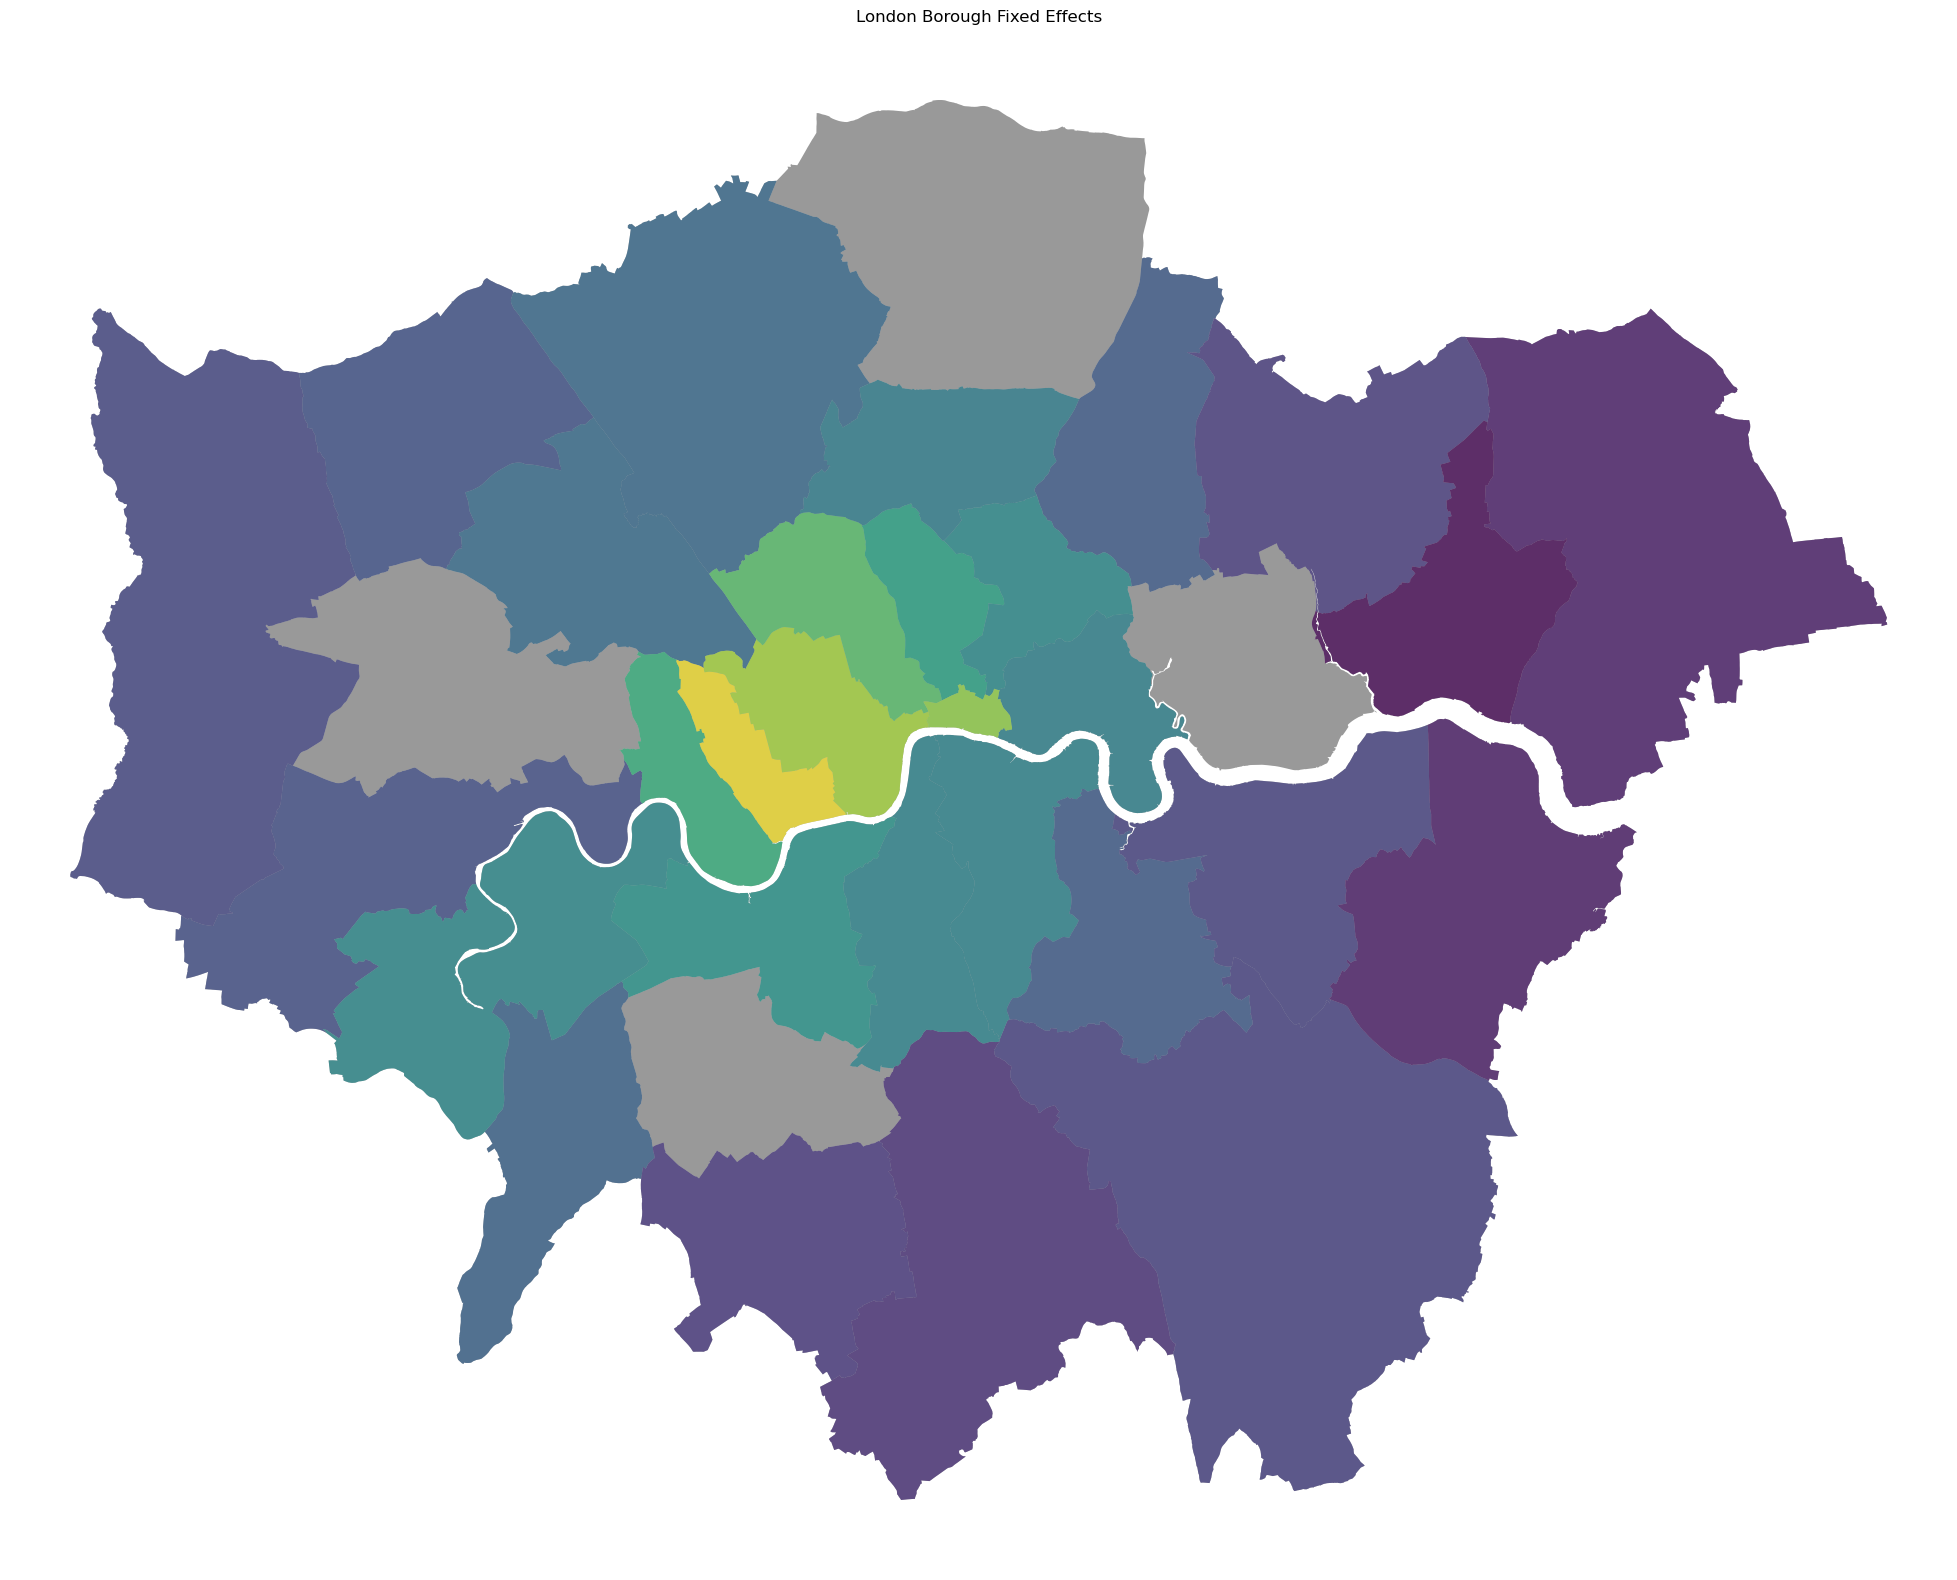

In [22]:
#extract variation in neighbourhood effects to have a look

neighbourhood_effects = model2.params.filter(like='NAME_2')
stripped = neighbourhood_effects.index.str.strip('NAME_2[').str.strip(']')
neighbourhood_effects.index = stripped
neighbourhood_effects = neighbourhood_effects.to_frame('fixed_effect')

#then create a "NAME" column that we can use to join back to the boroughs GeoJSON file
neighbourhood_effects['NAME'] = neighbourhood_effects.index
f, ax = plt.subplots(1, figsize=(25, 20)) #Subplots allows you to draw multiple plots in one figure
lb.to_crs('EPSG:3857').plot(ax=ax, color='k', alpha=0.4)
lb.merge(neighbourhood_effects, how='left',
                    left_on='NAME', 
                    right_on='NAME')\
                  .dropna(subset=['fixed_effect'])\
                  .to_crs('EPSG:3857').plot('fixed_effect',
                        ax=ax, alpha=.7)
ax.set_title("London Borough Fixed Effects")
ax.set_axis_off() #Remove axes from plot 
plt.axis('equal') #Set x and y axes to be equal size
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

We can clearly see that the prices vary by borough but we ideally would like to know what about each borough makes it more attractive. In practical 6, here he starts modelling distances to roads etc. - is this where we look at distances to schools? I am going to proceed as if that is the case. 

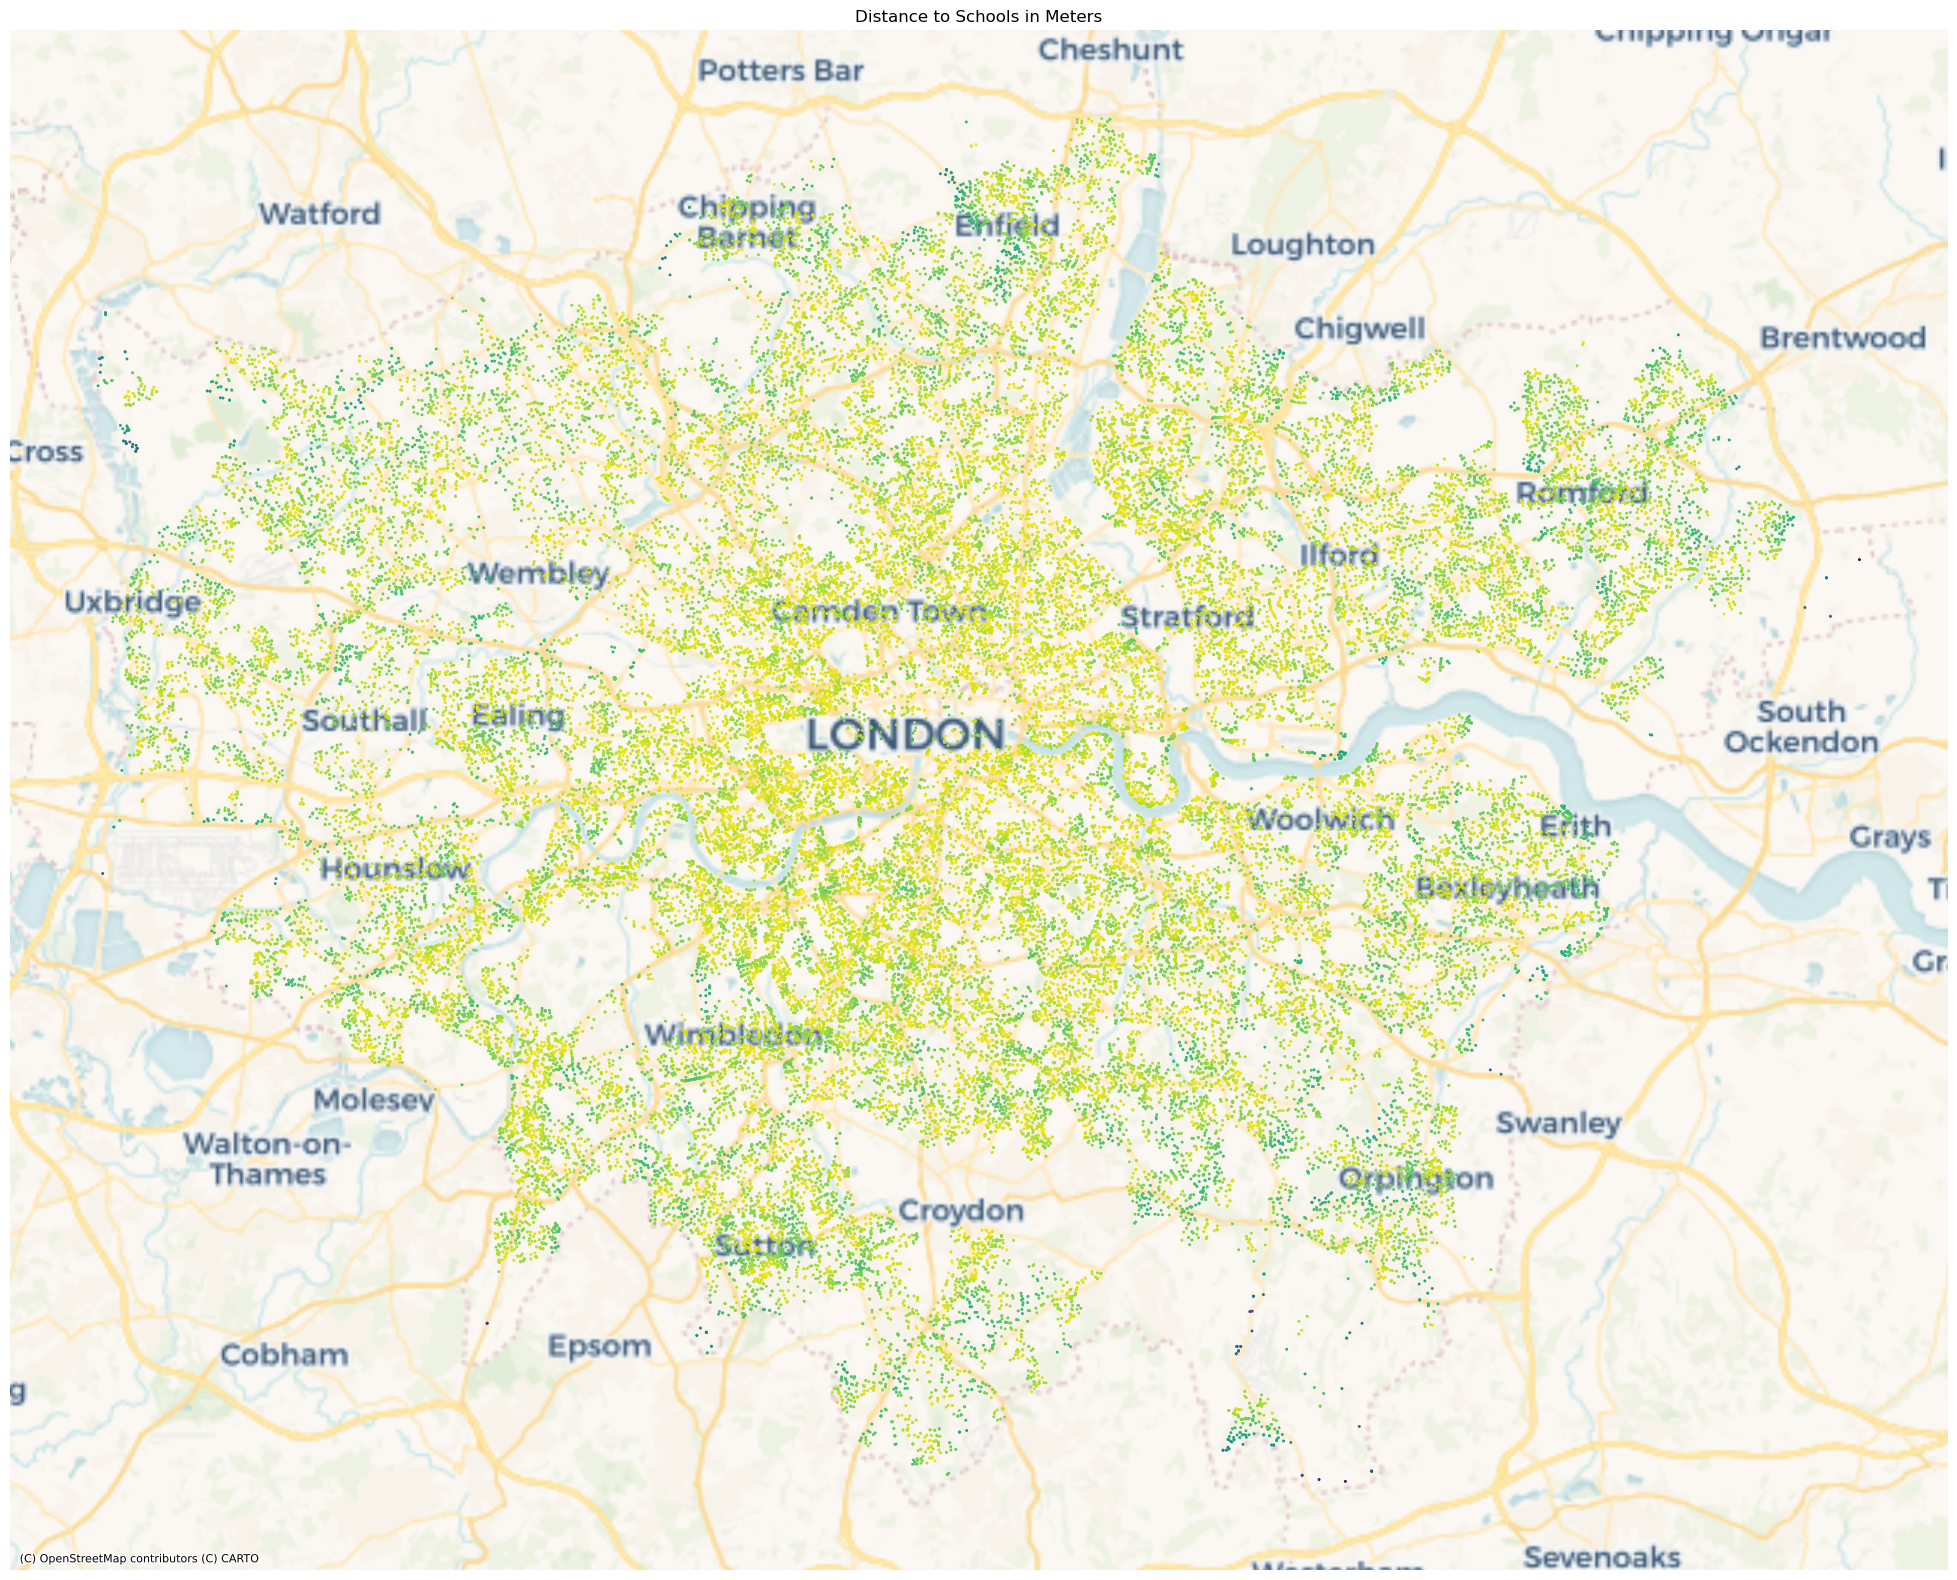

In [24]:

import contextily as cx
color_map = plt.cm.get_cmap('viridis')
reversed_color_map = color_map.reversed()

# Create a figure and axis
f, ax = plt.subplots(1, figsize=(25, 20))

# Plot the GeoDataFrame containing housing price data with distance to schools
hp_with_school_dist2.to_crs('EPSG:3857').plot(column='Dist_School', cmap=reversed_color_map, marker='.', s=5, ax=ax)

# Remove axes from the plot
ax.set_axis_off()

# Set plot title
ax.set_title('Distance to Schools in Meters')

# Ensure equal aspect ratio
plt.axis('equal')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

This map doesn't show a huge amount of variation across the boroughs but lets add the distance to the model anyway to see if it makes a difference. 

In [25]:
base_names = variable_names
dist_names = variable_names + ['Dist_School']

In [26]:
model3 = spreg.OLS(hp_with_school_dist2[['log_price']].values, hp_with_school_dist2[dist_names].values,
                name_y='log_price', name_x=dist_names, robust='white')
print(model3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           7
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63494
R-squared           :      0.5486
Adjusted R-squared  :      0.5486
Sum squared residual:     9161.44                F-statistic           :  12862.5012
Sigma-square        :       0.144                Prob(F-statistic)     :           0
S.E. of regression  :       0.380                Log likelihood        :  -28633.371
Sigma-square ML     :       0.144                Akaike info criterion :   57280.741
S.E of regression ML:      0.3798                Schwarz criterion     :   57344.153

White Standard Errors
--------------------------------------

Compared to model 1 our R-squared has increased from 0.53 to 0.55.. This is not a huge amount of increase but it still has increased. 

Question: Should we be adding in more predictors eg. distance to major roads etc to help our model fit? 

### Trying Spatial Lag of X Model (SLX)



In [33]:
wx = hp_with_school_dist2[variable_names].apply(
    lambda y: weights.spatial_lag.lag_spatial(w, y)
# Rename the spatial lag, adding w_ to the original name
).rename(
    columns=lambda c: 'w_'+c)
# Compute the spatial lag of each of those variables
wx

w_log_area  w_numberrooms  w_Flats  w_Detached  w_New
6        33.318092           40.0      0.0         3.0    0.0
133190   33.318092           40.0      0.0         3.0    0.0
144109   33.318092           40.0      0.0         3.0    0.0
25      365.864846          225.0     88.0         0.0   55.0
676     365.864846          225.0     88.0         0.0   55.0
...            ...            ...      ...         ...    ...
641062  372.483679          312.0     79.0         0.0    0.0
641148   75.094853           44.0     18.0         0.0    1.0
641178   75.094853           44.0     18.0         0.0    1.0
641149   98.826698           57.0     24.0         0.0    1.0
641153   78.547891           45.0     19.0         0.0    1.0

[63501 rows x 5 columns]

In [35]:
# Merge original variables with the spatial lags in `wx`
slx_exog = hp_with_school_dist2[dist_names].join(wx)
model4 = spreg.OLS(hp_with_school_dist2[['log_price']].values, slx_exog.values,
                name_y='log_price', name_x=slx_exog.columns.tolist(), robust='white', w=w, spat_diag=True, moran=True)
print(model4.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :          12
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63489
R-squared           :      0.6824
Adjusted R-squared  :      0.6824
Sum squared residual:     6446.09                F-statistic           :  12401.7862
Sigma-square        :       0.102                Prob(F-statistic)     :           0
S.E. of regression  :       0.319                Log likelihood        :  -17472.130
Sigma-square ML     :       0.102                Akaike info criterion :   34968.261
S.E of regression ML:      0.3186                Schwarz criterion     :   35076.967

White Standard Errors
--------------------------------------

R-squared is significantly increased to 0.68. 

### Trying Spatial Lag Model (SAR)

Using this to account for the fact that people are likely to set their house prices based on the prices of neighbouring houses. 

In [31]:

model5 = spreg.GM_Lag(hp_with_school_dist2[['log_price']].values, hp_with_school_dist2[dist_names].values,
                     w=w, name_y='log_price', name_x=dist_names, robust='white')
print(model5.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           8
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63493
Pseudo R-squared    :      0.5973
Spatial Pseudo R-squared:  0.5883

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         8.54609         0.03158       270.65989         0.00000
            log_area         0.97607         0.00855       114.21574         0.00000
         numberrooms

As you can see, the spatial lag parameter is significant and positive, indicating positive spatial dependence in the dependent variable. The other coefficients remain significant in this specification. R squared is improved to 0.59. 

### Trying Spatial Error Model (SEM)


In [32]:
model6 = spreg.GM_Error_Het(hp_with_school_dist2[['log_price']].values, hp_with_school_dist2[dist_names].values,
                     w=w, name_y='log_price', name_x=dist_names)
print(model6.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           7
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63494
Pseudo R-squared    :      0.5486
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         8.71068         0.03306       263.45196         0.00000
            log_area         1.00983         0.00893    

lamba is not significant so no point in using this model...